In [13]:
import sys
import os
from dotenv import load_dotenv
load_dotenv()
sys.path.insert(0, os.getenv('SRC_PATH'))

import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
from src.volsurface import GridInterpVolSurface, KernelVolSurface
from src.utils.data_helper import clean_data, VolSurfPointwiseDataset

import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from src.train import Trainer

import json

DB_PATH = os.getenv('DB_PATH')
CSV_PATH = os.getenv('CSV_PATH')
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

pd.set_option('future.no_silent_downcasting', True)

from src.utils.logger import setup_logger
logger = setup_logger('train')

In [82]:
model_name = "vae_pw_improve_0"
train_model = True
load_model = False
save_model = False
data_dir = CSV_PATH + "/predicted_vol_surfaces.json"  # Path to the volatility surfaces dataset
batch_size = 32
epochs = 8

In [83]:
maturity_grid = np.array([1, 7, 30, 60, 90, 180, 360, 720])
delta_grid = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

# delta_grid = np.linspace(0.1, 0.9, 9)
# maturity_grid = np.array([1, 7, 30, 60, 90, 180, 360])

In [84]:
SRC_PATH = os.getenv('SRC_PATH')
os.chdir(SRC_PATH)
trainer = Trainer(model_name)
trainer.create_model()

[2025-04-22 23:48:20] [INFO] src.train (62) : Using device: mps


In [85]:
with open(data_dir, "r") as f:
    data = json.load(f)

In [25]:
trainer.model.encoder.latent_dim

4

[2025-04-22 23:49:44] [INFO] src.train (138) : Model loaded from params/vae_pw_improve_0.pth


torch.Size([1, 8])


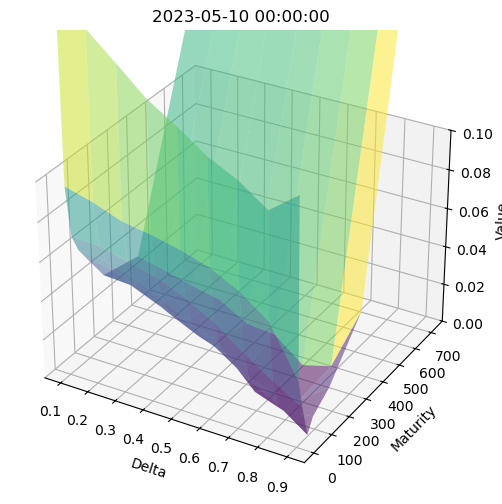

In [111]:
import random
date = random.choice(list(data.keys()))
tmp = torch.tensor(data[date]).flatten().to(trainer.device).view(1, -1)
mean, logvar = trainer.model.encoder(tmp)
mean
trainer.model.reparameterize(mean, logvar)
from src.volsurface import VAEPWVolSurface
trainer.load_model("params/vae_pw_improve_0.pth")
vaevsurf = VAEPWVolSurface(trainer.model, latent=mean.detach().cpu().numpy())
vaevsurf.refresh()
pred = vaevsurf.predict_grid(delta_grid, maturity_grid)
true = np.array(data[date])
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(delta_grid, maturity_grid, indexing='ij')

# # Plot true values
# ax.plot_surface(X, Y, true, color='red', alpha=0.2, label='True Values')

# # Plot predicted values
# ax.plot_surface(X, Y, pred, color='blue', alpha=0.2, label='Predicted Values')

ax.plot_surface(X, Y, np.abs(true - pred), cmap='viridis', alpha=0.5, label='Error Surface')

ax.set_title(date)
ax.set_xlabel('Delta')
ax.set_ylabel('Maturity')
ax.set_zlabel('Value')

ax.set_zlim(0, 0.1)

plt.show()


torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])


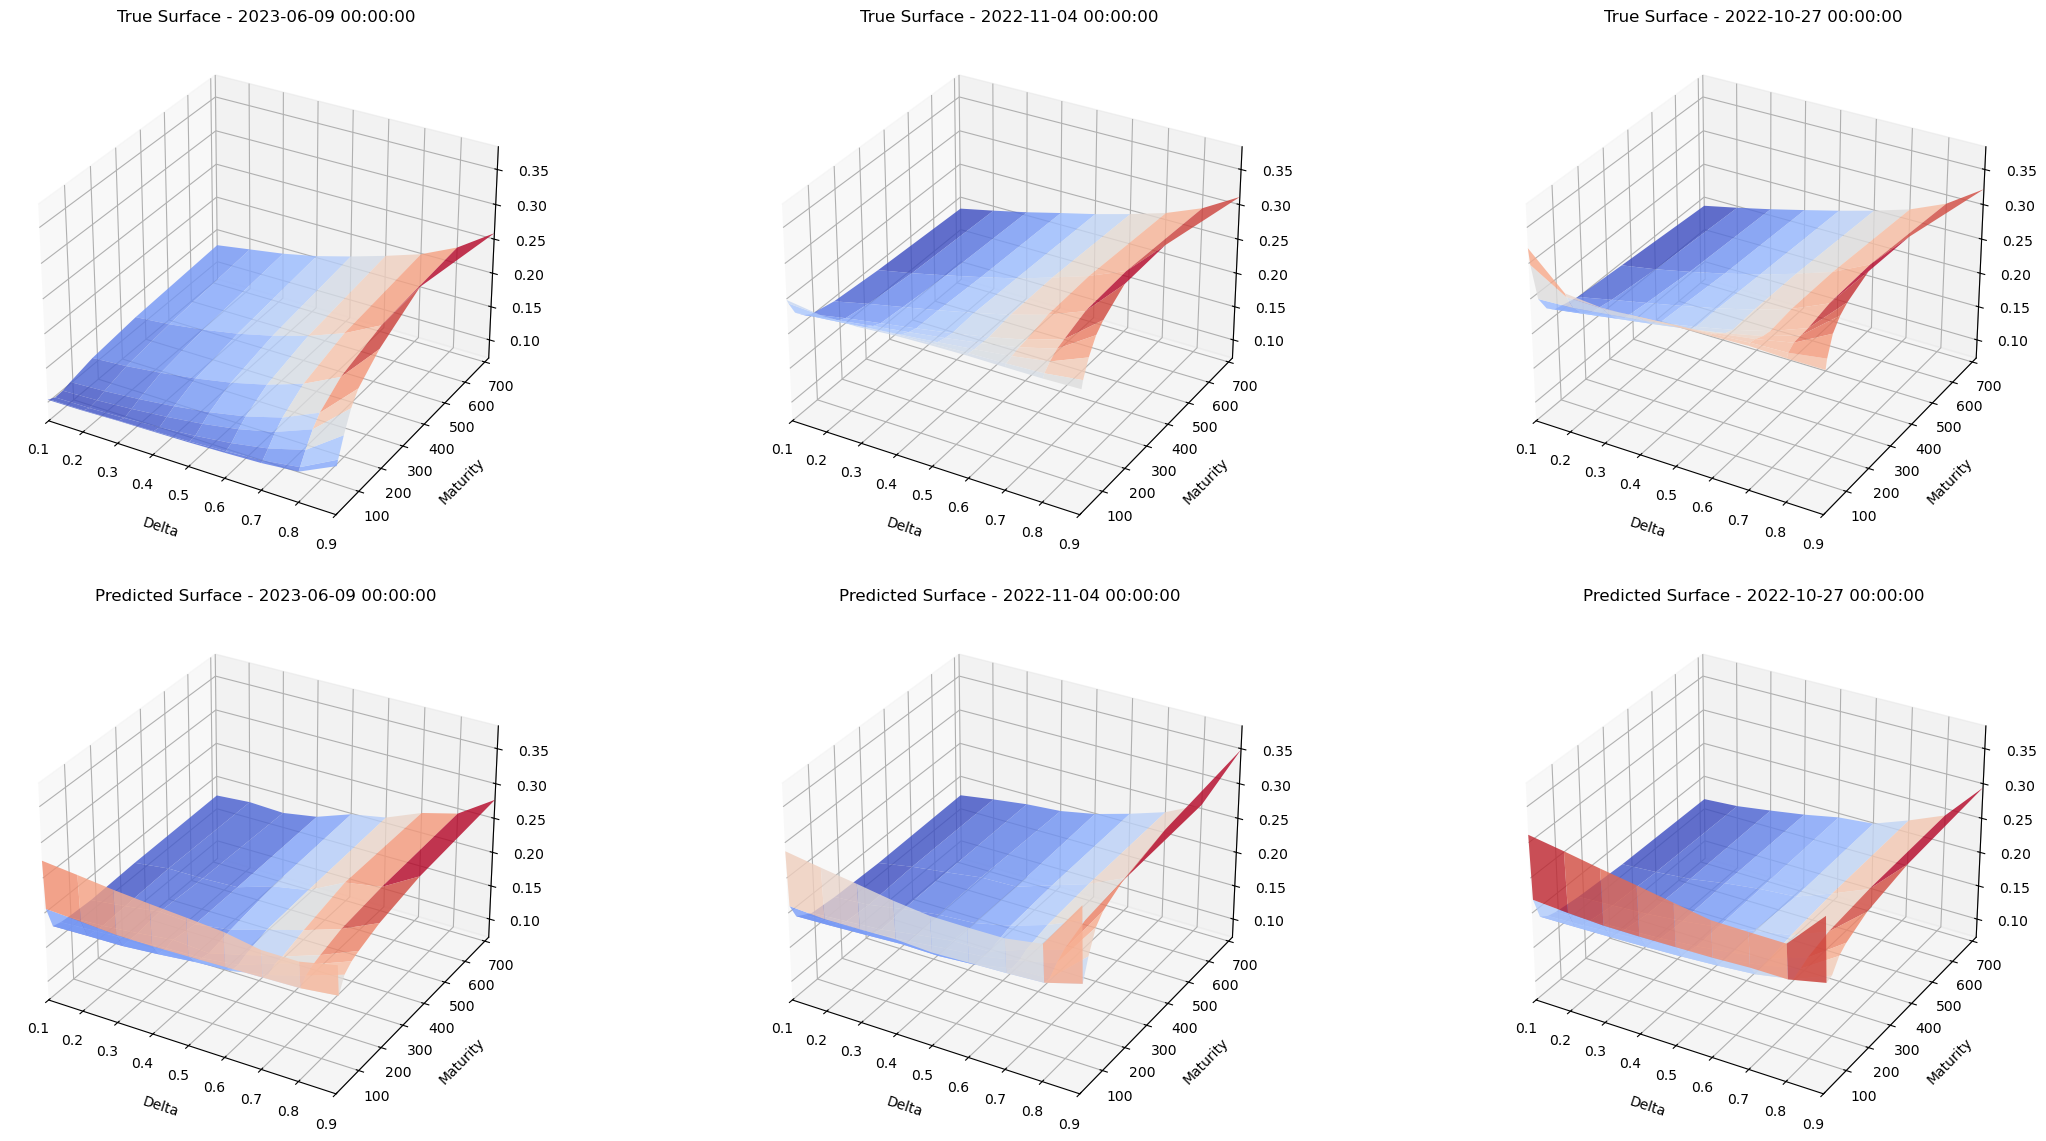

In [122]:
# Select 3 random dates
dates = random.sample(list(data.keys()), 3)

# Create figure with 2 rows and 3 columns
fig = plt.figure(figsize=(24, 12))  # Wider to fit 3 columns
X, Y = np.meshgrid(delta_grid, maturity_grid, indexing='ij')

# Store z-limits for consistent scaling
all_vol = []

for idx, date in enumerate(dates):
    # Generate data
    true = np.array(data[date])
    tmp = torch.tensor(data[date]).flatten().to(trainer.device).view(1, -1)
    mean, logvar = trainer.model.encoder(tmp)
    mean = mean.detach().cpu().numpy()
    logvar = logvar.detach().cpu().numpy()
    latent = mean + np.exp(logvar / 2) * np.random.randn(*mean.shape)
    vaevsurf = VAEPWVolSurface(trainer.model, latent=latent)
    pred = vaevsurf.predict_grid(delta_grid, maturity_grid)
    all_vol.extend([true, pred])

    # Determine subplot positions (2 rows, 3 columns)
    ax_true = fig.add_subplot(2, 3, idx + 1, projection='3d')
    ax_pred = fig.add_subplot(2, 3, idx + 4, projection='3d')

    # Plot true surface
    surf1 = ax_true.plot_surface(X, Y, true, cmap='coolwarm', alpha=0.8)
    ax_true.set_title(f'True Surface - {date}', pad=10)
    ax_true.set_xlabel('Delta', labelpad=10)
    ax_true.set_ylabel('Maturity', labelpad=10)
    ax_true.tick_params(axis='z', pad=8)

    # Plot predicted surface
    surf2 = ax_pred.plot_surface(X, Y, pred, cmap='coolwarm', alpha=0.8)
    ax_pred.set_title(f'Predicted Surface - {date}', pad=10)
    ax_pred.set_xlabel('Delta', labelpad=10)
    ax_pred.set_ylabel('Maturity', labelpad=10)
    ax_pred.tick_params(axis='z', pad=8)

# Calculate global z-axis limits with padding
all_vol = np.concatenate([arr.flatten() for arr in all_vol])
z_min = np.min(all_vol)
z_max = np.max(all_vol)
padding = 0.1 * (z_max - z_min)

# Set consistent axes for all subplots
for ax in fig.get_axes():
    if isinstance(ax, Axes3D):
        ax.set_xlim(np.min(delta_grid), np.max(delta_grid))
        ax.set_ylim(np.min(maturity_grid), np.max(maturity_grid))
        ax.set_zlim(z_min - padding, z_max + padding)

plt.tight_layout(pad=3.0)
plt.show()
